In [ ]:
!pip install swifter
!pip install transformers
!pip install simpletransformers

In [ ]:
import pandas as pd
import numpy as np
import glob
import re
import swifter
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification
from simpletransformers.ner import NERModel,NERArgs
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
def remove_punct(word):
    res = re.sub(r'[^\w\s %,-@]', '', word)
    return res

In [ ]:
def fix_percent(words, labels):
    for i in range(len(words)):
        if i == 0:
            continue
        else:
            if words[i] == '%' and words[i-1].isnumeric():
                labels[i-1] = 'B-QUANTITY-PER'
                labels[i] = 'I-QUANTITY-PER'
    return words, labels

In [ ]:
def fix_gb(words, labels):
    for i in range(len(words)):
        if i == 0:
            continue
        else:
            if words[i] == 'GB' and words[i-1].isnumeric():
                labels[i-1] = 'B-QUANTITY-NUM'
                labels[i] = 'I-QUANTITY-NUM'
    return words, labels

In [ ]:
def fix_distance(words, labels):
    for i in range(len(words)):
        if i == 0:
            continue
        else:
            if words[i] in ['cm', 'mm', 'km', 'm'] and words[i-1].isnumeric():
                if labels[i] == 'O':
                    labels[i-1] = 'B-QUANTITY-DIM'
                    labels[i] = 'I-QUANTITY-DIM'
    return words, labels

In [ ]:
def fix_distance_vie(words, labels):
    for i in range(len(words)):
        if i == 0:
            continue
        else:
            if i + 1 < len(words):
                if words[i] in ['triệu', 'nghìn', 'ngàn', 'tỉ', 'tỷ'] and words[i-1].isnumeric() and words[i+1] in ['cm', 'mm', 'km', 'm']:
                    labels[i-1] = 'B-QUANTITY-DIM'
                    labels[i] = 'I-QUANTITY-DIM'
                    labels[i+1] = 'I-QUANTITY-DIM'
    return words, labels

In [ ]:
def fix_currency_vie(words, labels):
    for i in range(len(words)):
        if i == 0:
            continue
        else:
            if i + 1 < len(words):
                if words[i] in ['triệu', 'nghìn', 'ngàn', 'tỉ', 'tỷ'] and words[i-1].isnumeric() and words[i+1] in ['đồng', "USD", 'euro']:
                    labels[i-1] = 'B-QUANTITY-CUR'
                    labels[i] = 'I-QUANTITY-CUR'
                    labels[i+1] = 'I-QUANTITY-CUR'
    return words, labels

In [ ]:
def fix_age(words, labels):
    for i in range(len(words)):
        if i == 0:
            continue
        else:
            if words[i] == 'tuổi' and words[i-1].isnumeric():
                labels[i-1] = 'B-QUANTITY-AGE'
                labels[i] = 'I-QUANTITY-AGE'
    return words, labels

In [ ]:
PREFIX_PATH = "/content/drive/MyDrive/ner-vietnamese/data/final/conll/*.conll"


In [ ]:
def pre_process(data):
    xxx = data
    Sentence = []
    Word = []
    POS = []
    Phrase = []
    NER_main = []
    Ner_extension = []
    sent_idx = 0
    files = glob.glob(PREFIX_PATH)

    for file in files:
        # print(file)
        with open(file, 'r') as f:
            full_text = f.readlines()
            for i in range(len(full_text)):
                full_text[i] = full_text[i].split('\t')
                if '.' in full_text[i] and '\n' in full_text[i + 1]:
                    sent_idx += 1
                elif '.' in full_text[i] and full_text[i + 1][0][0].isupper():
                    print(full_text[i + 1])
              
                    sent_idx += 1
                elif '\n' in full_text[i]:
                    sent_idx += 1
                else:
                    Sentence.append(sent_idx)
                    Word.append(full_text[i][0].replace('\ufeff', ''))
                    POS.append(full_text[i][1])
                    Phrase.append(full_text[i][2])

                    if len(full_text[i]) >= 4:
                        NER_main.append(full_text[i][3].replace('\n', ''))
                    else:
                        NER_main.append('O')

                    if len(full_text[i]) == 5:
                        Ner_extension.append(full_text[i][4].replace('\n', ''))
                    else:
                        Ner_extension.append('O')
        #             Sentence.append('-')
        #             Word.append('-')
        #             POS.append('-')
        #             Phrase.append('-')
        #             NER_main.append('-')
        #             Ner_extension.append('-')
        
    data = pd.DataFrame.from_dict({'Sentence': Sentence,'Word': Word, 'NER_main': NER_main, \
                                    'Ner_extension': Ner_extension})
    X = data[["Sentence","Word"]]
    Y = data["NER_main"]
    
    data = pd.DataFrame({"sentence_id":X["Sentence"],"words":X["Word"],"labels":Y})
    data['words'] = data['words'].swifter.apply(remove_punct)
    data = data[data['words'] != '']
    
    # fix percent
    sentence_id = data.sentence_id.tolist()
    words = data.words.tolist()
    labels = data.labels.tolist()
    
    if xxx == 'train':
        print('adsasd')
        words, labels = fix_percent(words, labels)
        words, labels = fix_gb(words, labels)
        words, labels = fix_distance(words, labels)
        words, labels = fix_age(words, labels)
        words, labels = fix_distance_vie(words, labels)
        words, labels = fix_currency_vie(words, labels)
    data = pd.DataFrame.from_dict({'sentence_id': sentence_id, 'words': words, 'labels': labels})
    return data

In [ ]:
data = pre_process('train')

Pandas Apply:   0%|          | 0/1003559 [00:00<?, ?it/s]

adsasd


In [ ]:
data.head(10)

,sentence_id,words,labels


In [ ]:
data.shape

(985774, 3)

In [ ]:
train = data.iloc[0:800000]
dev = data.iloc[800001:985773]

In [ ]:
label = train["labels"].unique().tolist()
# label

In [ ]:
args = NERArgs()
args.num_train_epochs = 1
args.learning_rate = 1e-4
args.overwrite_output_dir =True
args.train_batch_size = 8
args.eval_batch_size = 8
args.classification_report = True
# args.wandb_project = 'hieunm'
args.manual_seed = 2927

In [ ]:
model = NERModel('roberta', 'xlm-roberta-base',labels=label, args=args, use_cuda=True)

You are using a model of type xlm-roberta to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model c

In [ ]:
!pwd

In [ ]:

model.train_model(train, eval_data = dev, acc=accuracy_score, output_dir="report")

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/3328 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


(3328, 0.32659453840425645)

In [ ]:
true_df = dev.copy()

In [ ]:
result, model_outputs, preds_list = model.eval_model(true_df, output_dir='report/hieunm/')

In [ ]:
result, model_outputs, preds_list = model.eval_model(dev, output_dir='report/hieunm/')

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/792 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(result)

{'eval_loss': 0.21951432983754637, 'precision': 0.5512871602773571, 'recall': 0.5896343022760208, 'f1_score': 0.5698162945876926}


In [ ]:
len(preds_list)

6329

In [ ]:
!pip install sklearn-crfsuite

In [ ]:
from sklearn_crfsuite.metrics import flat_classification_report

In [ ]:
dev.head(10)

In [ ]:
dev['sentence_id'].nunique()

In [ ]:
len(preds_list)

In [ ]:
dev_count = dev.groupby('sentence_id')['words'].apply(list).reset_index(name='new')
# ['new'].apply(lambda x: len(x)).reset_index(name='count')

In [ ]:
def_feature = pd.DataFrame()
def_feature['collect_words'] = dev.groupby('sentence_id')['words'].apply(list)
def_feature['collect_label'] = dev.groupby('sentence_id')['labels'].apply(list)
def_feature['count_words'] = def_feature.apply(lambda row: len(row.collect_words), axis=1)

In [ ]:
def_feature.reset_index(drop=True, inplace= True)

In [ ]:
dev_count['count'] = dev_count.apply(lambda row: len(row.new), axis=1)

In [ ]:
dev_count.shape

(6329, 3)

In [ ]:
dev_count[824:827]

,sentence_id,new,count
824,38286,"[Trong, thời, gian, tới, ,, chúng, tôi, xác, đ...",26
825,38287,"[Trước, mắt, là, nâng, tầm, TTUB, thành, trung...",73
826,38288,"[Chiều, 21-9, tại, BV, Quân, y, 175, Bộ, Quốc,...",123


In [ ]:
dev_count = dev_count[dev_count.words == dev_count.labels]


In [ ]:
dev_count.reset_index(drop=True, inplace= True)

In [ ]:
x = []
for sen in preds_list :
  len_sen = len(sen)
  
  x.append([sen,len_sen])


In [ ]:
df_x = pd.DataFrame(x, columns = ['count_collect','pred'])

In [ ]:
# df_union=pd.concat([df_x["count_pred"],dev_count["words"]])

df_union=pd.concat([df_x, def_feature], axis=1)


In [ ]:
df_union.shape

(6329, 5)

In [ ]:
df_union.dtypes

count_collect     object
pred             float64
collect_words     object
collect_label     object
count_words      float64
dtype: object

In [ ]:
df_union_dif =df_union[df_union.pred != df_union.count_words]

In [ ]:
df_union_dif

,count_collect,pred,collect_words,collect_label,count_words
826,"[B-DATETIME, I-DATETIME-DATE, O, B-ORGANIZATIO...",109,"[Chiều, 21-9, tại, BV, Quân, y, 175, Bộ, Quốc,...","[B-DATETIME-DATE, I-DATETIME-DATE, O, B-ORGANI...",123
827,"[O, B-DATETIME-DURATION, I-DATETIME-DURATION, ...",96,"[Trong, 5, năm, qua, ,, hàng, năm, đều, tăng, ...","[O, B-QUANTITY-NUM, I-QUANTITY-NUM, O, O, O, O...",116
1013,"[O, O, O, O, O, B-DATETIME-TIME, I-DATETIME-TI...",106,"[Trước, đó, ,, vào, hồi, 23, giờ, 30, phút, ng...","[O, O, O, O, O, B-DATETIME, I-DATETIME, I-DATE...",121
2112,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",107,"[Cuốn, sách, kỷ, yếu, đề, cập, hàng, loạt, chủ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",189
2251,"[O, O, B-PRODUCT, O, O, O, B-LOCATION-GPE, I-L...",90,"[Hai, chiếc, Gepard, đầu, tiên, của, Việt, Nam...","[O, O, O, O, O, O, B-LOCATION-GPE, I-LOCATION-...",93
2481,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",109,"[Lần, tới, ,, khi, gặp, áp, lực, ,, hoặc, nếm,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",110
2656,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",97,"[Do, vậy, ,, kết, quả, sản, xuất, kinh, doanh,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",108
2767,"[B-PERSONTYPE, I-PERSONTYPE, B-PERSON, I-PERSO...",98,"[Trung, phong, Enes, Kanter, có, màn, thể, hiệ...","[O, O, B-PERSON, I-PERSON, O, O, O, O, O, O, O...",125
2812,"[B-LOCATION, I-LOCATION, I-LOCATION, O, B-ORGA...",109,"[Hồ, Chí, Minh, ;, Công, ty, Trách, nhiệm, hữu...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",154
2814,"[O, O, B-QUANTITY-NUM, O, O, O, O, O, O, O, O,...",106,"[Danh, sách, 46, cá, nhân, nhận, giải, thưởng,...","[O, O, O, O, O, O, O, O, O, O, O, O, B-PERSON,...",540


In [ ]:
df_same_length =df_union[df_union.pred == df_union.count_words]

In [ ]:
dev_count = dev_count[dev_count.words == dev_count.labels]

In [ ]:
pred_count = [ x for xs in preds_list for x in xs]

In [ ]:
preds_list[4]

In [ ]:
flat_preds_list = [x for xs in preds_list for x in xs]

In [ ]:
myset_pre = set(flat_preds_list)
print(len(myset_pre))

In [ ]:
dev.shape

In [ ]:
flat_true_list = dev.labels.tolist()

In [ ]:
myset = set(flat_true_list)
print(len(myset))

In [ ]:
z = myset.intersection(myset_pre)

print(len(z))

In [ ]:
k = myset.difference(myset_pre)
print(k)

In [ ]:
len(flat_preds_list)

In [ ]:
len(flat_true_list)

In [ ]:
prediction, model_output = model.predict(["bệnh viện Bạch Mai là một cơ sở khám bệnh tốt"])

In [ ]:
prediction

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
df_same_length

,count_collect,pred,collect_words,collect_label,count_words
0,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O]",14,"[dân, tộc, thiểu, số, là, rất, quan, trọng, ,,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O]",14
1,"[O, O, B-PERSON, I-PERSON]",4,"[Ảnh, :, Thanh, Sơn]","[O, O, B-PERSON, I-PERSON]",4
2,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",45,"[Sau, các, ý, kiến, phát, biểu, góp, ý, của, c...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",45
3,"[B-ORGANIZATION, I-ORGANIZATION, I-ORGANIZATIO...",15,"[Sở, Văn, hóa, và, Thể, thao, cần, sớm, hoàn, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",15
4,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",54,"[Trước, mắt, ,, UBND, tỉnh, đồng, ý, với, dự, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",54
...,...,...,...,...,...
6324,"[O, O, O, B-LOCATION, I-LOCATION, B-ORGANIZATI...",36,"[Tổ, hợp, rừng, Kaeng, Krachan, KKFC, nằm, tro...","[B-LOCATION, I-LOCATION, I-LOCATION, I-LOCATIO...",36
6325,"[B-ORGANIZATION, O, O, O, O, B-QUANTITY, I-QUA...",65,"[KKFC, có, tổng, diện, tích, 4.702, km2, với, ...","[B-LOCATION, O, O, O, O, B-QUANTITY-DIM, I-QUA...",65
6326,"[O, O, O, B-ORGANIZATION, O, O, O, O, O, B-ORG...",70,"[Trước, đó, ,, UNESCO, đã, từ, chối, công, nhậ...","[O, O, O, B-ORGANIZATION, O, O, O, O, O, B-LOC...",70
6327,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",38,"[KKFC, là, môi, trường, sống, của, nhiều, loài...","[B-LOCATION, O, O, O, O, O, O, O, O, O, O, O, ...",38


In [ ]:
true_list_all = df_same_length['collect_label'].tolist()
preds_list_all = df_same_length['count_collect'].tolist()

In [ ]:
flat_true =[]
flat_pred =[]

In [ ]:
for sent in true_list_all:
  for x in sent:
    flat_true.append(x)

for sent in preds_list_all:
  for x in sent:
    flat_pred.append(x)


In [ ]:
labels= ['B-PERSONTYPE',
 'B-PERSON',
 'B-ORGANIZATION',
 'B-LOCATION-GPE',
 'B-LOCATION',
 'B-DATETIME',
 'B-QUANTITY',
 'B-DATETIME-DATE',
 'B-PRODUCT',
 'B-QUANTITY-AGE',
 'B-DATETIME-SET',
 'B-QUANTITY-NUM',
 'B-MISCELLANEOUS',
 'B-QUANTITY-PER',
 'B-DATETIME-TIMERANGE',
 'B-EVENT-CUL',
 'B-QUANTITY-CUR',
 'B-ORGANIZATION-STOCK',
 'B-DATETIME-TIME',
 'B-LOCATION-STRUC',
 'B-ADDRESS',
 'B-QUANTITY-ORD',
 'B-DATETIME-DURATION',
 'B-LOCATION-GEO',
 'B-EVENT',
 'B-SKILL',
 'B-URL',
 'B-QUANTITY-DIM',
 'B-EVENT-SPORT',
 'B-PRODUCT-LEGAL',
 'B-ORGANIZATION-SPORTS',
 'B-DATETIME-DATERANGE',
 'B-QUANTITY-TEM',
 'B-ORGANIZATION-MED',
 'B-EVENT-GAMESHOW',
 'B-EMAIL',
 'B-PHONENUMBER',
 'B-*',
 'B-PRODUCT-COM',
 'B-IP',
 'B-EVENT-NATURAL',
 'B-PRODUCT-AWARD']

In [ ]:
!pip install sklearn-crfsuite

In [ ]:
from itertools import chain

import nltk
import sklearn
import scipy.stats

import sklearn_crfsuite
from sklearn_crfsuite import scorers,CRF
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite import metrics

In [ ]:
print(len(preds_list_all[100]))
print(len(true_list_all[100]))

15
15


In [ ]:
!pip install git+https://github.com/MeMartijn/updated-sklearn-crfsuite.git#egg=sklearn_crfsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/MeMartijn/updated-sklearn-crfsuite.git to /tmp/pip-install-uvh6qk7l/sklearn-crfsuite_0a90385e8e224dfb88f4f6f35ed1423f
  Running command git clone -q https://github.com/MeMartijn/updated-sklearn-crfsuite.git /tmp/pip-install-uvh6qk7l/sklearn-crfsuite_0a90385e8e224dfb88f4f6f35ed1423f


In [ ]:
from sklearn_crfsuite import metrics
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    true_list_all, preds_list_all, labels=sorted_labels, digits=3
))

TypeError: ignored

In [ ]:


def make_report(true_df, preds_list):

  true_df.reset_index(drop=True, inplace= True)
  print('test size:', true_df.shape)
  def_feature = pd.DataFrame()
  def_feature['collect_words'] = true_df.groupby('sentence_id')['words'].apply(list)
  def_feature['collect_label'] = true_df.groupby('sentence_id')['labels'].apply(list)
  def_feature['count_words'] = def_feature.apply(lambda row: len(row.collect_words), axis=1)
  def_feature.reset_index(drop=True, inplace= True)
  
  x = []
  for sen in preds_list :
    len_sen = len(sen)
    x.append([sen,len_sen])
  df_preds = pd.DataFrame(x, columns = ['collect_words_pred','count_words_pred'])

  df_union=pd.concat([df_preds, def_feature], axis=1)

  df_union_dif =df_union[df_union.count_words_pred != df_union.count_words]
  print('diff sentence: ', df_union_dif.shape)

  df_same_length =df_union[df_union.count_words_pred == df_union.count_words]
  print('same sentence: ', df_same_length.shape)

  true_list_all = df_same_length['collect_label'].tolist()
  preds_list_all = df_same_length['count_collect'].tolist()

  flat_true =[]
  flat_pred =[]
  for sent in true_list_all:
  for x in sent:
    flat_true.append(x)

  for sent in preds_list_all:
    for x in sent:
      flat_pred.append(x)

  labels= ['B-PERSONTYPE',
  'B-PERSON',
  'B-ORGANIZATION',
  'B-LOCATION-GPE',
  'B-LOCATION',
  'B-DATETIME',
  'B-QUANTITY',
  'B-DATETIME-DATE',
  'B-PRODUCT',
  'B-QUANTITY-AGE',
  'B-DATETIME-SET',
  'B-QUANTITY-NUM',
  'B-MISCELLANEOUS',
  'B-QUANTITY-PER',
  'B-DATETIME-TIMERANGE',
  'B-EVENT-CUL',
  'B-QUANTITY-CUR',
  'B-ORGANIZATION-STOCK',
  'B-DATETIME-TIME',
  'B-LOCATION-STRUC',
  'B-ADDRESS',
  'B-QUANTITY-ORD',
  'B-DATETIME-DURATION',
  'B-LOCATION-GEO',
  'B-EVENT',
  'B-SKILL',
  'B-URL',
  'B-QUANTITY-DIM',
  'B-EVENT-SPORT',
  'B-PRODUCT-LEGAL',
  'B-ORGANIZATION-SPORTS',
  'B-DATETIME-DATERANGE',
  'B-QUANTITY-TEM',
  'B-ORGANIZATION-MED',
  'B-EVENT-GAMESHOW',
  'B-EMAIL',
  'B-PHONENUMBER',
  'B-PRODUCT-COM',
  'B-IP',
  'B-EVENT-NATURAL',
  'B-PRODUCT-AWARD']

  flat_true_coff = []
  lat_preds_coff = []

  for sent in true_list_all:
    for x in sent:
        if '-' in x:
            x = x.split('-')[1]
        flat_true_coff.append(x) 

  for sent in preds_list_all:
    for x in sent:
      if '-' in x:
          x = x.split('-')[1]
      flat_preds_coff.append(x) 

  print(len(flat_preds_coff))
  print(len(flat_true_coff))

  label_rm_begin = []
  for x in labels:
      if '-' in x:
          x = x.split('-')[1]
      label_rm_begin.append(x)
  label_rm_begin = list(set(label_rm_begin))
  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
  import matplotlib.pyplot as plt


  cm = confusion_matrix(flat_preds_coff, flat_true_coff, labels=label_rm_begin)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_rm_begin)
  fig, ax = plt.subplots(figsize=(15,15))

  disp.plot(ax=ax)
  plt.xticks(rotation = 90)
  plt.show()  


In [ ]:
flat_true_coff = []
flat_preds_coff = []

In [ ]:
for sent in true_list_all:
  for x in sent:
    if '-' in x:
        x = x.split('-')[1]
    flat_true_coff.append(x) 

for sent in preds_list_all:
  for x in sent:
    if '-' in x:
        x = x.split('-')[1]
    flat_preds_coff.append(x) 

In [ ]:
print(len(flat_preds_coff))
print(len(flat_true_coff))

181908
181908


In [ ]:
# for x in flat_preds_list_all:
#     if '-' in x:
#         x = x.split('-')[1]
#     flat_preds_list_all.append(x)

In [ ]:
len(labels)

42

In [ ]:
label_rm_begin = []
for x in labels:
    if '-' in x:
        x = x.split('-')[1]
    label_rm_begin.append(x)
# labels.remove('O')
# for lab in labels:
#   # if lab.startswith("I"):
#   #   labels.remove(lab)
    
  # if str(lab).startswith('I'):
  #   labels.remove(lab)
label_rm_begin = list(set(label_rm_begin))

In [ ]:
len(label_rm_begin)

15

In [ ]:
label_rm_begin.remove("*")

In [ ]:
%matplotlib inline

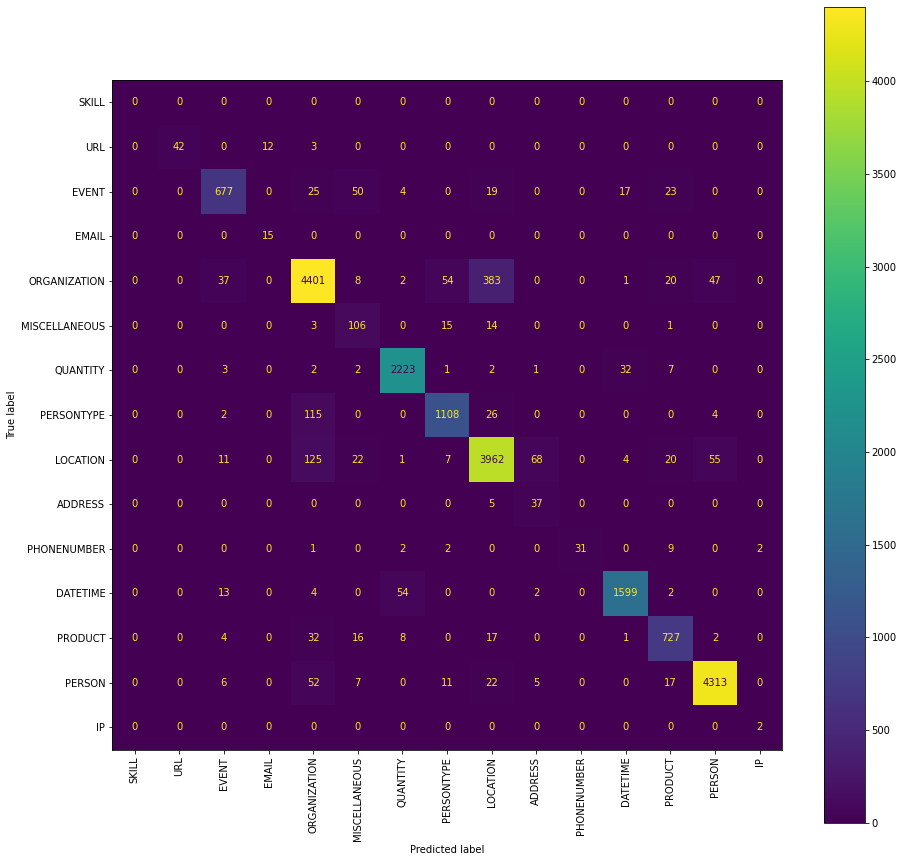

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


cm = confusion_matrix(flat_preds_coff, flat_true_coff, labels=label_rm_begin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_rm_begin)
fig, ax = plt.subplots(figsize=(15,15))

disp.plot(ax=ax)
plt.xticks(rotation = 90)
plt.show()

## PHÂN TÍCH NHÃN

In [ ]:
def get_example(label, threshold=3):
    l = label.split('-')
    if len(l) == 3:
        key = label[2:]
    else:
        key = l[1]
    df_ex = train[train['labels'] == label]
    i = 0
    for i in range(0, threshold):
        sent_id = df_ex.iloc[i]['sentence_id']
        df_sent = train[train['sentence_id'] == sent_id]
        for index, row in df_sent.iterrows():
            if key in row['labels']:
                print(row['words'], row['labels'])
        print('------------------')
#         for j = i, j < i + 4, j++:
#             print(df_sent.i)
#         print(df_sent)

In [ ]:
get_example('B-DATETIME-DATE', 500)

In [ ]:
get_example('B-DATETIME-TIME', 500)

In [ ]:
train[train['words'] == 'CLB']

In [ ]:
train[train['sentence_id'] == 2]

In [ ]:
train[train['labels'] == 'B-DATETIME-DATE']

In [ ]:
test[test['labels'] == 'B-SKILL']

In [ ]:
test[test['sentence_id'] == 6623]

## Xác định dùng luật

In [ ]:
# global value
vn_provinces = ['Hòa Bình', 'Sơn La', 'Điện Biên', 'Lai Châu', 'Lào Cai', 'Yên Bái', 'Phú Thọ', 'Hà Giang', 'Tuyên Quang', 'Cao Bằng', 'Bắc Kạn', 'Thái Nguyên', 'Lạng Sơn', 'Bắc Giang', 'Quảng Ninh', \
               'Hà Nội', 'Bắc Ninh', 'Hà Nam', 'Hải Dương', 'Hải Phòng', 'Hưng Yên', 'Nam Định', 'Thái Bình', 'Vĩnh Phúc', 'Ninh Bình', 'Thanh Hóa', 'Nghệ An', 'Hà Tĩnh', 'Quảng Bình', 'Quảng Trị', \
                'Thừa Thiên Huế', 'Đà Nẵng', 'Quảng Nam', 'Quảng Ngãi', 'Bình Định', 'Phú Yên', 'Khánh Hòa', 'Ninh Thuận', 'Bình Thuận', 'Kon Tum', 'Gia Lai', 'Đắk Lắk', 'Lâm Đồng', 'Hồ Chí Minh', \
                'Bà Rịa Vũng Tàu', 'Bình Dương', 'Bình Phước', 'Đồng Nai', 'Tây Ninh', 'An Giang', 'Bạc Liêu', 'Bến Tre', 'Cà Mau', 'Cần Thơ', 'Đồng Tháp', 'Hậu Giang', 'Kiên Giang', 'Long An', 'Sóc Trăng', \
                'Tiền Giang', 'Trà Vinh', 'Vĩnh Long']

In [ ]:
test_sentence = 'huyện Kỳ Sơn là một trong những huyện giàu ở tiểu bang Washington ở Việt Nam'

In [ ]:
# location-gpe
test_sentence = [word for word in test_sentence.split()]

In [ ]:
def location_gpe(sentence):
    label_sentence = ['O'] * len(sentence)
    for i in range(len(sentence)):
        if sentence[i] in ['thôn', 'xã', 'phường', 'huyện', 'tỉnh', 'bang']:
            for j in range(i + 1, len(sentence)):
                if sentence[j][0].isupper():
                    if sentence[i-1] == 'tiểu':
                        label_sentence[i-1] = 'B-LOCATION-GPE'
                        label_sentence[i] = 'I-LOCATION-GPE'
                        label_sentence[j] = 'I-LOCATION-GPE'
                    else:
                        label_sentence[i] = 'B-LOCATION-GPE'
                        label_sentence[j] = 'I-LOCATION-GPE'
                else:
                    break
        elif sentence[i][0].isupper() and (sentence[i-1] not in ['thôn', 'xã', 'phường', 'huyện', 'tỉnh', 'bang']):
            maybe_province = [sentence[i]]
            for j in range(i + 1, len(sentence)):
                if sentence[j][0].isupper():
                    maybe_province.append(sentence[j])
                    # print(maybe_province)
                else:
                    end = j - 1
                    break
                
            maybe_province = ' '.join(maybe_province)
            if maybe_province in vn_provinces:
                label_sentence[i] = 'B-LOCATION-GPE'
                for j in range(i+1, end+1):
                    label_sentence[j] = 'I-LOCATION-GPE'
    for key, value in zip(sentence, label_sentence):
        print(key, value)
    # return label_sentence

In [ ]:
location_gpe(train[train['sentence_id'] == 0]['words'].tolist())

In [ ]:
test[test['sentence_id'] == 4].head(20)

In [ ]:

prediction, model_output = model.predict([" ".join(test[test['sentence_id'] == 4]['words'].tolist())])
prediction